# Evaluating Weak-to-Strong Generalization in Large Language Models: Fine-Tuning for Social Media Disinformation Detection with a Focus on Green AI


This research explores weak-to-strong generalization in large language models (LLMs) to address social media disinformation campaigns. The experiment focuses on fine-tuning a stronger model (GPT-4.0 mini) with synthetic outputs generated by a weaker model (GPT-3.5), testing the model’s ability to generate authentic control tweets. This process simulates real-world disinformation strategies and aims to understand how well a more powerful model can refine and replicate the linguistic patterns of disinformation.


Research Questions:
1. Weak to strong generalisation: Investigating how effectively a stronger model improves its performance through iterative fine-tuning using the outputs of a weaker model.
2. Siamese Neural Network (SNN) with Different Embeddings: Exploring the performance of the SNN model and LSTM when trained with distinct embeddings (BERT vs. GPT-2) and assessing their ability to detect AI-generated tweets
3. Green AI Considerations: Assessing the computational costs and energy efficiency (Green AI) of GPT-3.5 and GPT-4.0 mini models, tracking API usage, tokens, and processing time to evaluate resource consumption and sustainability.



# Data 

To ensure consistency across all experiments, a fixed seed dataset of tweets was generated from 'opposer' and 'supporter' accounts that included the hashtag #ArsonEmergency. This dataset was generated once and used across all experiments to allow for repeatable and comparable results. The seed generation process was automated and the code is provided in the "Seed-data.py" file.




In [1]:
import pandas as pd

# File paths for the seed data
opposer_seed_file = 'opposer_seed_data.csv'
supporter_seed_file = 'supporter_seed_data.csv'

# Load the seed data for opposers and supporters
opposer_seed_data = pd.read_csv(opposer_seed_file)
supporter_seed_data = pd.read_csv(supporter_seed_file)

# Display the first few rows of each dataset
print("Opposer Seed Data:")
print(opposer_seed_data.head())

print("\nSupporter Seed Data:")
print(supporter_seed_data.head())

Opposer Seed Data:
   account_number                                              tweet
0        54517921  BBC Fact Check on #ArsonEmergency claims.  htt...
1        54517921  #Murdoch is the Father of Lies. \n\nThere is n...
2        54517921  @hardenuppete @QUT I made a list of the 10 big...
3        54517921  Twitter bots and trolls promote conspiracy the...
4       616046769  @Aristot38316720 @MikeCarlton01 Closely follow...

Supporter Seed Data:
   account_number                                              tweet
0        35709385  ARSON EMERGENCY UPDATE\n\n"716 fires this seas...
1        35709385  #ArsonEmergency\n\n@ToomeyWright \n\n. https:/...
2        35709385  😆😆😆😆😆😆😆😆😆 #ArsonEmergency https://t.co/AlWzObzZb3
3        35709385  @labor_trash @guardian I’m going to start hash...
4        35709385  As the Global Warming myth unravels, the Clima...


# Prompt

This control prompt is used throughout this notebook to generate controlled, authentic-looking tweets for further analysis.

In [2]:
CONTROL_PROMPT = "Generate a closely related tweet that subtly varies in wording but retains the essence and context of the original tweet: {}. Return only the modified tweet."

# Weak GPT Model

This class interacts with the OpenAI API using the gpt-3.5-turbo-instruct model to generate refined control tweets through iterative prompting.

In [3]:
import openai
from openai import OpenAI
import logging
import re
import os

class WeakChatGPTHandler:
    def __init__(self, api_key,model):
        self.client = OpenAI(api_key=api_key)
        self.model = model
    
    def _make_request(self, prompt, temperature=1.0, max_tokens=256, top_p=1.0, frequency_penalty=0.5, presence_penalty=0.5, stop=None):
        """
        Make a request to the OpenAI API with control over temperature, top_p, frequency_penalty, presence_penalty, and stop sequences.
        """
        try:
            #logging.info(f"Sending prompt: {prompt}")
            response = self.client.completions.create(
                model=self.model,
                prompt=prompt,
                temperature=temperature,      # Maximize randomness
                max_tokens=max_tokens,        # Max tokens for tweet length
                top_p=top_p,                  # Nucleus sampling, diverse output
                frequency_penalty=frequency_penalty,  # Discourages repetition
                presence_penalty=presence_penalty,    # Encourages new topics/words
                stop=stop                    # No stop sequence for tweet generation
            )
            generated_text = response.choices[0].text.strip()
            #logging.info(f"Generated text: {generated_text}")
            return generated_text
        except Exception as e:
            logging.error(f"Error making request: {e}")
            return None

    def control_tweet(self, tweet):
        prompt = CONTROL_PROMPT.format(tweet)
        return self._make_request(prompt)


def iterative_prompting(seed_data, num_iterations):
    """
    Perform iterative prompting over multiple iterations to refine control tweets.
    
    Args:
        seed_data (pd.DataFrame): The seed dataset containing original tweets.
        num_iterations (int): The number of iterations to refine the tweets.
        
    Returns:
        pd.DataFrame: A DataFrame containing the final refined tweets.
    """
    current_tweets = seed_data['tweet'].tolist()  # List of original tweets
    
    # Iterate over the number of iterations
    for iteration in range(num_iterations):
        
        # Store refined tweets for the current iteration
        refined_tweets = []
        
        # Generate refined control tweets for each tweet in the current set
        for tweet in current_tweets:
            refined_tweet = weak_chatgpt_handler.control_tweet(tweet)
            if refined_tweet:
                refined_tweets.append(refined_tweet)
            else:
                refined_tweets.append(tweet)  # Keep the original tweet if there's an error

        # Update the current_tweets to be the newly refined tweets
        current_tweets = refined_tweets
    
    # Convert the final refined tweets to a DataFrame
    refined_tweets_df = pd.DataFrame({
        'original_tweet': seed_data['tweet'],
        'refined_tweet': current_tweets
    })
    
    return refined_tweets_df

# Retrieve API key from environment variables
api_key_gpt = os.getenv('OPENAI_API_KEY')

# Create an instance of WeakChatGPTHandler for GPT-3.5-turbo-instruct model
weak_chatgpt_handler = WeakChatGPTHandler(api_key_gpt, model="gpt-3.5-turbo-instruct")


In [4]:
# Usage:
refined_opposer_tweets = iterative_prompting(opposer_seed_data, num_iterations=3)

# Save the refined opposer tweets to a CSV file
refined_opposer_tweets.to_csv('refined_opposer_tweets.csv', index=False)

refined_supporter_tweets = iterative_prompting(supporter_seed_data, num_iterations=3)

# Save the refined tweets supporter to a CSV file
refined_supporter_tweets.to_csv('refined_supporter_tweets.csv', index=False)


# Load the refined tweets from the CSV file into the variable
#refined_opposer_tweets = pd.read_csv('refined_opposer_tweets.csv')
#refined_supporter_tweets = pd.read_csv('refined_supporter_tweets.csv')


# Strong GPT Model

This class handles interactions with the OpenAI API using the gpt-4.0-mini model to generate control tweets. 

In [5]:
class StrongChatGPTHandler:
    def __init__(self, api_key, model):
        self.client = openai.OpenAI(api_key=api_key)
        self.model = model

    def _make_request(self, prompt, temperature=1.0, max_tokens=256, top_p=1.0, frequency_penalty=0.5, presence_penalty=0.5, stop=None):
        try:
            response = self.client.chat.completions.create(
                model=self.model,
                messages=[
                    {"role": "system", "content": "You are a tweeter assistant that rephrases tweets well, return only the tweet without further ado."},
                    {"role": "user", "content": prompt}
                ],
                temperature=temperature,
                max_tokens=max_tokens,
                top_p=top_p,
                frequency_penalty=frequency_penalty,
                presence_penalty=presence_penalty
            )
            generated_text = response.choices[0].message.content.strip()
            return generated_text
        except Exception as e:
            print(f"Error making request: {e}")
            return None

    def control_tweet(self, tweet):
        # Format and send the control tweet prompt to the model
        prompt = CONTROL_PROMPT.format(tweet)
        return self._make_request(prompt)


# Retrieve API key and initialize the strong GPT-4.0-mini handler
api_key = os.getenv('OPENAI_API_KEY')

strong_chatgpt_handler = StrongChatGPTHandler(api_key=api_key, model="gpt-4o-mini")


In [6]:
def generate_gpt4_tweets(refined_gpt3_data):
    """
    This function generates two versions of tweets using GPT-4.0 mini: one based on the original tweet and another based on the refined version of the tweet from GPT-3.5.
    
    Args:
        refined_gpt3_data (pd.DataFrame): DataFrame containing original and GPT-3.5 refined tweets.
        
    Returns:
        pd.DataFrame: DataFrame containing GPT-4.0 mini outputs for both tweets.
    """
    gpt4_tweets_from_gpt3 = []
    gpt4_tweets_from_original = []

    # Iterate over the refined and original tweets
    for index,row in refined_gpt3_data.iterrows():
        original_tweet = row['original_tweet']
        refined_tweet = row['refined_tweet']

        # GPT-4-o-mini generated tweet based on the original tweet
        gpt4_output_from_original = strong_chatgpt_handler.control_tweet(original_tweet)
        gpt4_tweets_from_original.append(gpt4_output_from_original)

        # GPT-4-o-mini generated tweet based on the GPT-3.5 refined tweet
        gpt4_output_from_gpt3 = strong_chatgpt_handler.control_tweet(refined_tweet)
        gpt4_tweets_from_gpt3.append(gpt4_output_from_gpt3)

    # Create a DataFrame with GPT-4-o-mini outputs
    comparison_df = pd.DataFrame({
        'original_tweet': refined_gpt3_data['original_tweet'],
        'gpt3_refined_tweet': refined_gpt3_data['refined_tweet'],
        'gpt4_generated_from_original': gpt4_tweets_from_original,
        'gpt4_generated_from_gpt3': gpt4_tweets_from_gpt3
    })

    return comparison_df

In [7]:
comparison_results_opposer = generate_gpt4_tweets(refined_opposer_tweets)
comparison_results_supporter = generate_gpt4_tweets(refined_supporter_tweets)

# Save the comparison results to CSV
comparison_results_opposer.to_csv('gpt3_vs_gpt4_tweet_comparison_opposer.csv', index=False)
comparison_results_supporter.to_csv('gpt3_vs_gpt4_tweet_comparison_supporter.csv', index=False)

# Metrics

### Polarity and Subjectivity

We combine two sentiment analysis tools—SpacyTextBlob and VADER—to evaluate the emotional tone (polarity) and subjective content (subjectivity) of the tweets. 

In [8]:
# Importing necessary libraries
import spacy  # NLP library
from spacytextblob.spacytextblob import SpacyTextBlob  # Sentiment analysis extension for spaCy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer  # VADER sentiment analysis tool

# Load the spaCy model and add the SpacyTextBlob pipeline component
nlp = spacy.load('en_core_web_sm')  # Loading the small English model for spaCy
nlp.add_pipe('spacytextblob')  # Adding the SpacyTextBlob component for sentiment analysis

# Initialize the VADER sentiment analyzer
vader_analyzer = SentimentIntensityAnalyzer()  # Setting up the VADER sentiment analyzer

# Ensemble learning method to combine the sentiment analysis from SpacyTextBlob and VADER
def polarity_subjectivity(text):
    # SpacyTextBlob Analysis
    doc = nlp(text)  # Process the text using spaCy
    blob_polarity = doc._.blob.polarity  # Extracting the polarity score from SpacyTextBlob (-1 to 1)
    blob_subjectivity = doc._.blob.subjectivity  # Extracting the subjectivity score from SpacyTextBlob (0 to 1)
    
    # VADER Analysis
    vader_scores = vader_analyzer.polarity_scores(text)  # Analyze the text using VADER
    vader_polarity = vader_scores['compound']  # Extracting the compound polarity score from VADER (-1 to 1)
    vader_subjectivity = abs(vader_scores['pos'] - vader_scores['neg'])  # Estimating subjectivity as the difference between positive and negative scores (not directly provided by VADER)
    
    # Ensemble Averaging (simple average, can be adjusted to weighted average if needed)
    polarity = (blob_polarity + vader_polarity) / 2  # Averaging the polarity scores from both models
    subjectivity = (blob_subjectivity + vader_subjectivity) / 2  # Averaging the subjectivity scores from both models
    
    return {
        "polarity": polarity,  # Final averaged polarity score
        "subjectivity": subjectivity  # Final averaged subjectivity score
    }


In [9]:
# 1. Apply Polarity and Subjectivity
def apply_polarity_subjectivity(df):
    # Original Tweet Polarity and Subjectivity
    df['original_polarity'] = df['original_tweet'].apply(lambda tweet: polarity_subjectivity(tweet)['polarity'])
    df['original_subjectivity'] = df['original_tweet'].apply(lambda tweet: polarity_subjectivity(tweet)['subjectivity'])

    # GPT-3.5 Refined Tweet Polarity and Subjectivity
    df['gpt3_polarity'] = df['gpt3_refined_tweet'].apply(lambda tweet: polarity_subjectivity(tweet)['polarity'])
    df['gpt3_subjectivity'] = df['gpt3_refined_tweet'].apply(lambda tweet: polarity_subjectivity(tweet)['subjectivity'])

    # GPT-4-o-mini Generated Tweet Polarity and Subjectivity (From Original)
    df['gpt4_original_polarity'] = df['gpt4_generated_from_original'].apply(lambda tweet: polarity_subjectivity(tweet)['polarity'])
    df['gpt4_original_subjectivity'] = df['gpt4_generated_from_original'].apply(lambda tweet: polarity_subjectivity(tweet)['subjectivity'])

    # GPT-4-o-mini Generated Tweet Polarity and Subjectivity (From GPT-3.5 Refined)
    df['gpt4_gpt3_polarity'] = df['gpt4_generated_from_gpt3'].apply(lambda tweet: polarity_subjectivity(tweet)['polarity'])
    df['gpt4_gpt3_subjectivity'] = df['gpt4_generated_from_gpt3'].apply(lambda tweet: polarity_subjectivity(tweet)['subjectivity'])
    
    return df


comparison_results_opposer = pd.read_csv('gpt3_vs_gpt4_tweet_comparison_opposer.csv')
comparison_results_supporter = pd.read_csv('gpt3_vs_gpt4_tweet_comparison_supporter.csv')

# Apply polarity and subjectivity to comparison_results_opposer
comparison_results_opposer = apply_polarity_subjectivity(comparison_results_opposer)

# Apply polarity and subjectivity to comparison_results_supporter
comparison_results_supporter = apply_polarity_subjectivity(comparison_results_supporter)

### BLEU

The BLEU (Bilingual Evaluation Understudy) score is used to evaluate how similar the generated tweets are to the original reference tweets by comparing their n-grams.


In [10]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk

#Corpus BLEU vs Sentence BLEU

# Define the BLEU score function
def calculate_bleu(reference_text, generated_text):
    # Tokenize the reference text; wrap it in another list to create a list of lists
    reference_tokens = [nltk.word_tokenize(reference_text)]
    
    # Tokenize the generated text; this is just a single list of tokens
    generated_tokens = nltk.word_tokenize(generated_text)
    
    # Apply smoothing to handle zero counts for n-grams not found in the reference
    smoothing_function = SmoothingFunction().method1
    
    # Calculate the BLEU score comparing the generated tokens to the reference tokens
    bleu_score = sentence_bleu(reference_tokens, generated_tokens, smoothing_function=smoothing_function)
    
    return bleu_score


In [11]:
# 2. Apply BLEU Score
def apply_bleu_score(df):
    # BLEU Score between Original and GPT-3.5 Refined Tweet
    df['gpt3_bleu'] = df.apply(lambda row: calculate_bleu(row['original_tweet'], row['gpt3_refined_tweet']), axis=1)
    
    # BLEU Score between Original and GPT-4-o-mini Generated Tweet (From Original)
    df['gpt4_bleu_from_original'] = df.apply(lambda row: calculate_bleu(row['original_tweet'], row['gpt4_generated_from_original']), axis=1)
    
    # BLEU Score between Original and GPT-4-o-mini Generated Tweet (From GPT-3.5 Refined)
    df['gpt4_bleu_from_gpt3'] = df.apply(lambda row: calculate_bleu(row['original_tweet'], row['gpt4_generated_from_gpt3']), axis=1)
    
    return df

comparison_results_opposer = apply_bleu_score(comparison_results_opposer)
comparison_results_supporter = apply_bleu_score(comparison_results_supporter)

In [12]:
# Print a few rows to check the results
print(comparison_results_supporter.head())

                                      original_tweet  \
0  ARSON EMERGENCY UPDATE\n\n"716 fires this seas...   
1  #ArsonEmergency\n\n@ToomeyWright \n\n. https:/...   
2  😆😆😆😆😆😆😆😆😆 #ArsonEmergency https://t.co/AlWzObzZb3   
3  @labor_trash @guardian I’m going to start hash...   
4  As the Global Warming myth unravels, the Clima...   

                                  gpt3_refined_tweet  \
0  "Breaking: After investigation, no evidence of...   
1  "Swift call to action to tackle #ArsonEmergenc...   
2  🔥🚒 The escalation of fire-related occurrences ...   
3  "Thinking about making #ArsonCrisis my new go-...   
4  As the disintegration of the Global Warming na...   

                        gpt4_generated_from_original  \
0  ARSON EMERGENCY ALERT\n\n"This season, 716 fir...   
1  #FireCrisis\n\n@ToomeyWright \n\n. https://t.c...   
2    😂😂😂😂😂😂😂😂😂 #FireDisaster https://t.co/AlWzObzZb3   
3  @labor_trash @guardian From now on, I’ll be us...   
4  As the Global Warming narrative falls apart

# SNN

### Contribution: Integrating SNN and LSTM Models for Tweet Classification

Pre-trained Siamese Neural Networks (SNN) are combined with LSTM models to classify tweets as either GPT-generated or human-generated. This approach leverages two embedding strategies: GPT-2 embeddings and BERT embeddings. Each variation utilizes the SNN for generating embeddings from the tokenized tweets and the LSTM model for classification based on these embeddings.

### GPT-2 Embeddings + SNN + LSTM
GPT-2 embeddings, followed by SNN and LSTM for classification.

In [13]:
import tensorflow as tf
import torch
from transformers import GPT2Tokenizer
from transformers import BertTokenizer, BertModel
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# GPT-2 Tokenizer setup
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Load the pre-trained SNN (Transformer-based model for embeddings)
snn_model_path = 'siamGPTDetect/models/GPT35Detector_variousTopics_gpt2'  # SNN path
snn_model = tf.saved_model.load(snn_model_path)
snn_infer = snn_model.signatures['serving_default']  # Inference function for SNN

# Load the pre-trained LSTM model (for classification)
lstm_model_path = 'siamGPTDetect/models/model_NeuralNetCombi_GPT35Detector_variousTopics'  # LSTM path
lstm_model = tf.saved_model.load(lstm_model_path)
lstm_infer = lstm_model.signatures['serving_default']  # Inference function for LSTM

# Define the function for tweet classification using both SNN and LSTM
def snn_gpt2(tweet, threshold=0.5):
    max_seq_len = 150
    
    # Step 1: Tokenize and pad the tweet
    tweet_encoded = tokenizer([tweet])['input_ids']
    tweet_padded = pad_sequences(tweet_encoded, maxlen=max_seq_len, padding='post', truncating='post', value=0)
    tweet_padded_tensor = tf.convert_to_tensor(tweet_padded, dtype=tf.float32)
    
    # Step 2: Generate embeddings using the SNN
    embeddings = snn_infer(tf.convert_to_tensor(tweet_padded_tensor))['output_0']  # SNN output key

    # Step 3: Make predictions using the LSTM model (takes embeddings as input)
    prediction_prob = lstm_infer(tf.convert_to_tensor(embeddings))['dense_1']  # LSTM output key
    human_generated_prob = prediction_prob[0][0].numpy()  # Convert Tensor to a number
    gpt_generated_prob = prediction_prob[0][1].numpy()  # Convert Tensor to a number
    
    # Step 4: Apply a threshold to classify as GPT-generated or human-written
    classification = 'GPT-generated' if gpt_generated_prob > threshold else 'Human-generated'
    
    return {
        'classification': classification,
        'human_generated_prob': human_generated_prob,
        'gpt_generated_prob': gpt_generated_prob
    }

# Example usage with BERT embeddings
tweet = "What are people's thoughts on climate action as kicks off?"
result_bert = snn_gpt2(tweet)
print(result_bert)


2024-09-30 19:21:35.027445: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


{'classification': 'Human-generated', 'human_generated_prob': 0.9999461, 'gpt_generated_prob': 5.3848464e-05}


In [14]:
# 5.  Apply SNN_GPT2 for GPT-3.5 , GPT-4-o-mini and gpt4_gpt3 Tweets
def apply_snn_gpt2(df):
    # GPT-3.5 Refined Tweet Classification
    df['gpt3_snn_gpt2_detectability'] = df['gpt3_refined_tweet'].apply(lambda tweet: snn_gpt2(tweet)['classification'])
    df['gpt3_snn_gpt2_human_prob'] = df['gpt3_refined_tweet'].apply(lambda tweet: snn_gpt2(tweet)['human_generated_prob'])
    df['gpt3_snn_gpt2_gpt_prob'] = df['gpt3_refined_tweet'].apply(lambda tweet: snn_gpt2(tweet)['gpt_generated_prob'])

    # GPT-4-o-mini Generated Tweet (From Original) Classification
    df['gpt4_original_snn_gpt2_detectability'] = df['gpt4_generated_from_original'].apply(lambda tweet: snn_gpt2(tweet)['classification'])
    df['gpt4_original_snn_gpt2_human_prob'] = df['gpt4_generated_from_original'].apply(lambda tweet: snn_gpt2(tweet)['human_generated_prob'])
    df['gpt4_original_snn_gpt2_gpt_prob'] = df['gpt4_generated_from_original'].apply(lambda tweet: snn_gpt2(tweet)['gpt_generated_prob'])

    # GPT-4-o-mini Generated Tweet (From GPT-3.5 Refined) Classification
    df['gpt4_gpt3_snn_gpt2_detectability'] = df['gpt4_generated_from_gpt3'].apply(lambda tweet: snn_gpt2(tweet)['classification'])
    df['gpt4_gpt3_snn_gpt2_human_prob'] = df['gpt4_generated_from_gpt3'].apply(lambda tweet: snn_gpt2(tweet)['human_generated_prob'])
    df['gpt4_gpt3_snn_gpt2_gpt_prob'] = df['gpt4_generated_from_gpt3'].apply(lambda tweet: snn_gpt2(tweet)['gpt_generated_prob'])

    return df
# Apply the function to both DataFrames
comparison_results_opposer = apply_snn_gpt2(comparison_results_opposer)
comparison_results_supporter = apply_snn_gpt2(comparison_results_supporter)

# Print the column names to verify
print("Columns in comparison_results_opposer:")
print(comparison_results_opposer.columns)

Columns in comparison_results_opposer:
Index(['original_tweet', 'gpt3_refined_tweet', 'gpt4_generated_from_original',
       'gpt4_generated_from_gpt3', 'original_polarity',
       'original_subjectivity', 'gpt3_polarity', 'gpt3_subjectivity',
       'gpt4_original_polarity', 'gpt4_original_subjectivity',
       'gpt4_gpt3_polarity', 'gpt4_gpt3_subjectivity', 'gpt3_bleu',
       'gpt4_bleu_from_original', 'gpt4_bleu_from_gpt3',
       'gpt3_snn_gpt2_detectability', 'gpt3_snn_gpt2_human_prob',
       'gpt3_snn_gpt2_gpt_prob', 'gpt4_original_snn_gpt2_detectability',
       'gpt4_original_snn_gpt2_human_prob', 'gpt4_original_snn_gpt2_gpt_prob',
       'gpt4_gpt3_snn_gpt2_detectability', 'gpt4_gpt3_snn_gpt2_human_prob',
       'gpt4_gpt3_snn_gpt2_gpt_prob'],
      dtype='object')


### BERT Embeddings + SNN + LSTM
Follows the same steps but uses BERT embeddings as the input to the SNN and LSTM models.

In [15]:
# Initialize BERT model and tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Load the pre-trained BERT SNN model (Transformer-based model for embeddings)
bert_model_path = 'siamGPTDetect/models/GPT35Detector_variousTopics_bert'  # BERT SNN path
bert_model = tf.saved_model.load(bert_model_path)
bert_infer = bert_model.signatures['serving_default']  # Inference function for BERT SNN

# Load the pre-trained LSTM model (for classification)
lstm_model_path = 'siamGPTDetect/models/BERT_SNN_LSTM_Model'  # LSTM path
lstm_model = tf.saved_model.load(lstm_model_path)
lstm_infer = lstm_model.signatures['serving_default']  # Inference function for LSTM

# Define the function for tweet classification using both BERT SNN and LSTM
def snn_bert(tweet, threshold=0.5):
    max_seq_len = 150
    
    # Step 1: Tokenize and pad the tweet using BERT tokenizer
    tweet_encoded = bert_tokenizer([tweet])['input_ids']
    tweet_padded = pad_sequences(tweet_encoded, maxlen=max_seq_len, padding='post', truncating='post', value=0)
    tweet_padded_tensor = tf.convert_to_tensor(tweet_padded, dtype=tf.float32)
    
    # Step 2: Generate embeddings using the BERT SNN
    embeddings = bert_infer(tf.convert_to_tensor(tweet_padded_tensor))['output_0']  # BERT SNN output key

    # Step 3: Make predictions using the LSTM model (takes embeddings as input)
    # To ensure CPU compatibility, ensure that LSTM is set up to work with CPU-only
    # We need to use the CPU-compatible version of LSTM
    prediction_prob = lstm_infer(tf.convert_to_tensor(embeddings))['output_0']  # LSTM output key
    human_generated_prob = prediction_prob[0][0].numpy()  # Convert Tensor to a number
    gpt_generated_prob = prediction_prob[0][1].numpy()  # Convert Tensor to a number
    
    # Step 4: Apply a threshold to classify as GPT-generated or human-written
    classification = 'GPT-generated' if gpt_generated_prob > threshold else 'Human-generated'
    
    return {
        'classification': classification,
        'human_generated_prob': human_generated_prob,
        'gpt_generated_prob': gpt_generated_prob
    }

# Example usage with BERT embeddings
tweet = "What are people's thoughts on climate action as kicks off?"
result_bert = snn_bert(tweet)
print(result_bert)


{'classification': 'GPT-generated', 'human_generated_prob': 0.14377706, 'gpt_generated_prob': 0.8562229}


In [16]:
#6. Apply snn_bert
def apply_snn_bert(df):
    # Initialize lists to store results
    gpt3_classifications, gpt3_human_probs, gpt3_gpt_probs = [], [], []
    gpt4_original_classifications, gpt4_original_human_probs, gpt4_original_gpt_probs = [], [], []
    gpt4_gpt3_classifications, gpt4_gpt3_human_probs, gpt4_gpt3_gpt_probs = [], [], []
    
    # Iterate through each row of the DataFrame and apply the SNN_BERT classification function
    for index, row in df.iterrows():
        # GPT-3.5 Refined Tweet Classification
        gpt3_result = snn_bert(row['gpt3_refined_tweet'])
        gpt3_classifications.append(gpt3_result['classification'])
        gpt3_human_probs.append(gpt3_result['human_generated_prob'])
        gpt3_gpt_probs.append(gpt3_result['gpt_generated_prob'])
        
        # GPT-4-o-mini Generated Tweet (From Original) Classification
        gpt4_original_result = snn_bert(row['gpt4_generated_from_original'])
        gpt4_original_classifications.append(gpt4_original_result['classification'])
        gpt4_original_human_probs.append(gpt4_original_result['human_generated_prob'])
        gpt4_original_gpt_probs.append(gpt4_original_result['gpt_generated_prob'])
        
        # GPT-4-o-mini Generated Tweet (From GPT-3.5 Refined) Classification
        gpt4_gpt3_result = snn_bert(row['gpt4_generated_from_gpt3'])
        gpt4_gpt3_classifications.append(gpt4_gpt3_result['classification'])
        gpt4_gpt3_human_probs.append(gpt4_gpt3_result['human_generated_prob'])
        gpt4_gpt3_gpt_probs.append(gpt4_gpt3_result['gpt_generated_prob'])
    
    # Assign the lists back to the DataFrame
    df['gpt3_snn_bert_detectability'] = gpt3_classifications
    df['gpt3_snn_bert_human_prob'] = gpt3_human_probs
    df['gpt3_snn_bert_gpt_prob'] = gpt3_gpt_probs
    
    df['gpt4_original_snn_bert_detectability'] = gpt4_original_classifications
    df['gpt4_original_snn_bert_human_prob'] = gpt4_original_human_probs
    df['gpt4_original_snn_bert_gpt_prob'] = gpt4_original_gpt_probs
    
    df['gpt4_gpt3_snn_bert_detectability'] = gpt4_gpt3_classifications
    df['gpt4_gpt3_snn_bert_human_prob'] = gpt4_gpt3_human_probs
    df['gpt4_gpt3_snn_bert_gpt_prob'] = gpt4_gpt3_gpt_probs
    
    return df

# Apply the function to both DataFrames
comparison_results_opposer = apply_snn_bert(comparison_results_opposer)
comparison_results_supporter = apply_snn_bert(comparison_results_supporter)

# Print the column names to verify
print("Columns in comparison_results_opposer:")
print(comparison_results_opposer.columns)



Columns in comparison_results_opposer:
Index(['original_tweet', 'gpt3_refined_tweet', 'gpt4_generated_from_original',
       'gpt4_generated_from_gpt3', 'original_polarity',
       'original_subjectivity', 'gpt3_polarity', 'gpt3_subjectivity',
       'gpt4_original_polarity', 'gpt4_original_subjectivity',
       'gpt4_gpt3_polarity', 'gpt4_gpt3_subjectivity', 'gpt3_bleu',
       'gpt4_bleu_from_original', 'gpt4_bleu_from_gpt3',
       'gpt3_snn_gpt2_detectability', 'gpt3_snn_gpt2_human_prob',
       'gpt3_snn_gpt2_gpt_prob', 'gpt4_original_snn_gpt2_detectability',
       'gpt4_original_snn_gpt2_human_prob', 'gpt4_original_snn_gpt2_gpt_prob',
       'gpt4_gpt3_snn_gpt2_detectability', 'gpt4_gpt3_snn_gpt2_human_prob',
       'gpt4_gpt3_snn_gpt2_gpt_prob', 'gpt3_snn_bert_detectability',
       'gpt3_snn_bert_human_prob', 'gpt3_snn_bert_gpt_prob',
       'gpt4_original_snn_bert_detectability',
       'gpt4_original_snn_bert_human_prob', 'gpt4_original_snn_bert_gpt_prob',
       'gpt4_gpt3_

# Results

In this section, we plot all metrics applied to the tweets—original, GPT-3.5 refined, and GPT-4.0 mini-generated—using polarity, subjectivity, BLEU scores, and detectability classifications. These plots visually assess the differences in sentiment, linguistic similarity, and detectability between AI-generated and human-generated content for all variations of the tweets.

In [17]:

# Save the results for opposer to a CSV file
comparison_results_opposer.to_csv('opposer_results_with_metrics.csv', index=False)

# Save the results for supporter to a CSV file
comparison_results_supporter.to_csv('supporter_results_with_metrics.csv', index=False)

opposer_results_with_metrics=pd.read_csv('opposer_results_with_metrics.csv')
supporter_results_with_metrics = pd.read_csv('supporter_results_with_metrics.csv')

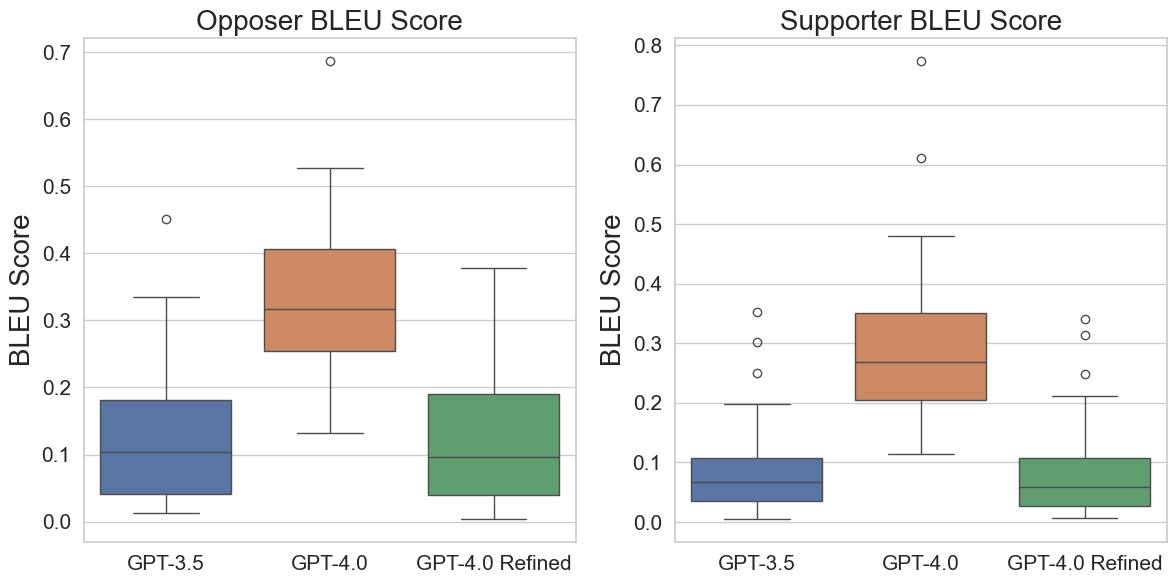

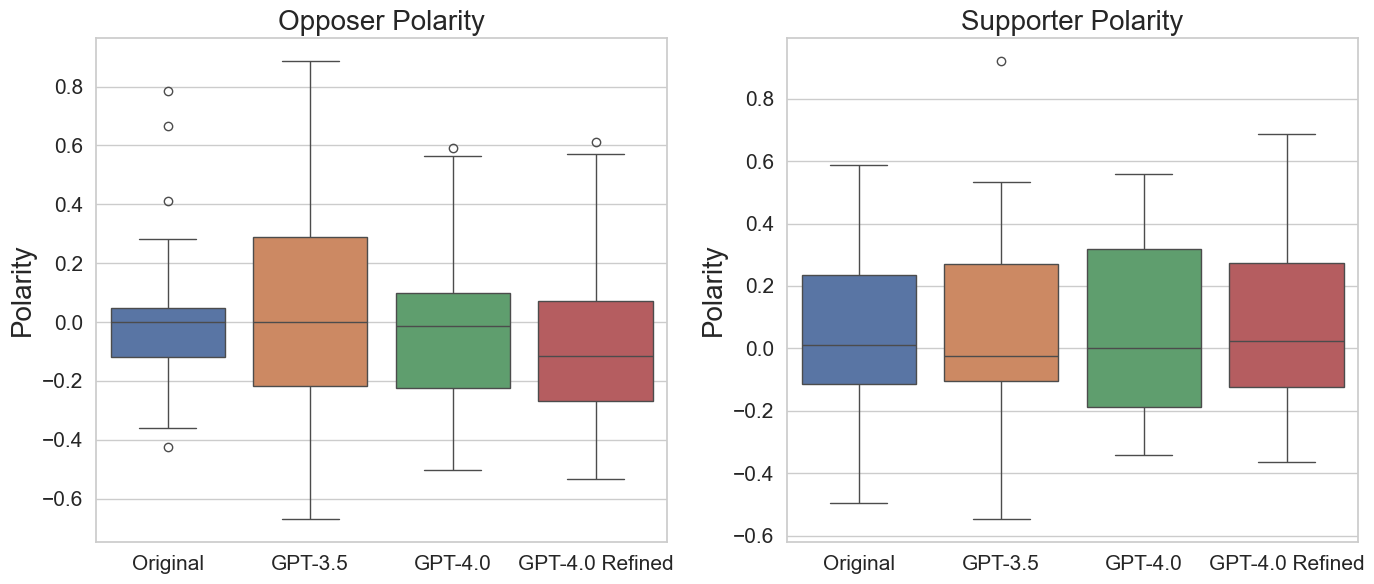

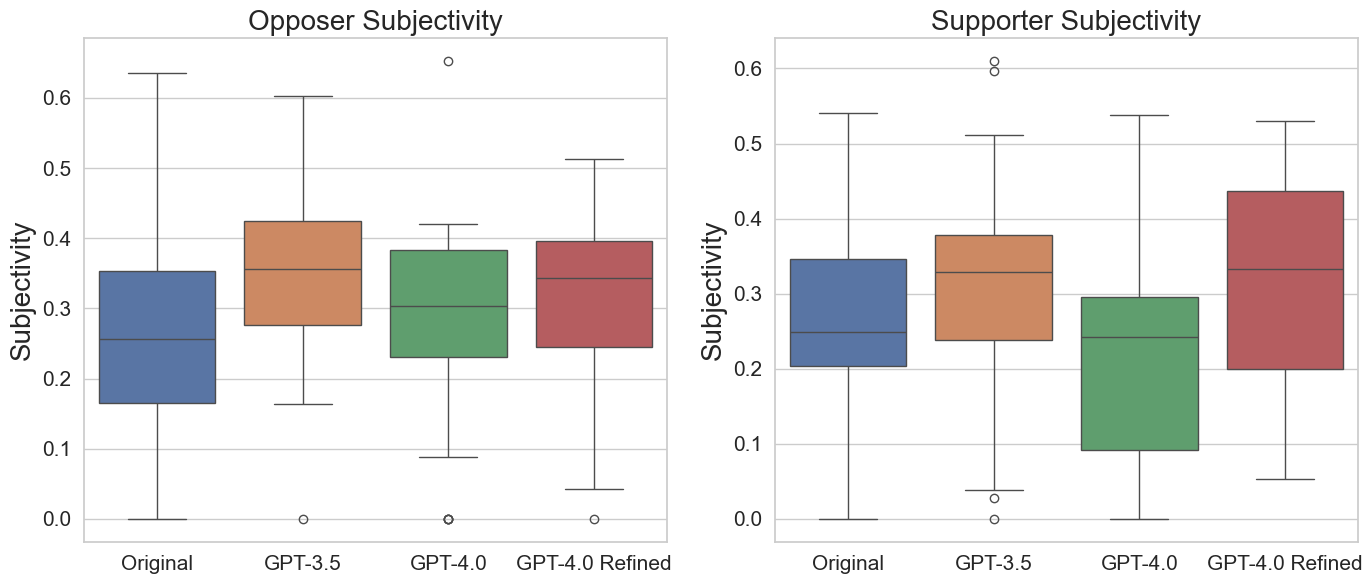

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up seaborn style for better aesthetics
sns.set(style="whitegrid")

# Set font size for labels and ticks
label_fontsize = 20
tick_fontsize = 15

# Plot 1: BLEU Scores comparison for GPT-3.5 and GPT-4.0 (Opposer vs Supporter)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=opposer_results_with_metrics[['gpt3_bleu', 'gpt4_bleu_from_original', 'gpt4_bleu_from_gpt3']])
plt.title("Opposer BLEU Score", fontsize=label_fontsize)
plt.ylabel("BLEU Score", fontsize=label_fontsize)
plt.xticks([0, 1, 2], ['GPT-3.5', 'GPT-4.0', 'GPT-4.0 Refined'], fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)

plt.subplot(1, 2, 2)
sns.boxplot(data=supporter_results_with_metrics[['gpt3_bleu', 'gpt4_bleu_from_original', 'gpt4_bleu_from_gpt3']])
plt.title("Supporter BLEU Score", fontsize=label_fontsize)
plt.ylabel("BLEU Score", fontsize=label_fontsize)
plt.xticks([0, 1, 2], ['GPT-3.5', 'GPT-4.0', 'GPT-4.0 Refined'], fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)

plt.tight_layout()
plt.show()

# Plot 2: Polarity comparison for original, GPT-3.5, and GPT-4.0 generated tweets (Opposer vs Supporter)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=opposer_results_with_metrics[['original_polarity', 'gpt3_polarity', 'gpt4_original_polarity', 'gpt4_gpt3_polarity']])
plt.title("Opposer Polarity", fontsize=label_fontsize)
plt.ylabel("Polarity", fontsize=label_fontsize)
plt.xticks([0, 1, 2, 3], ['Original', 'GPT-3.5', 'GPT-4.0', 'GPT-4.0 Refined'], fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)

plt.subplot(1, 2, 2)
sns.boxplot(data=supporter_results_with_metrics[['original_polarity', 'gpt3_polarity', 'gpt4_original_polarity', 'gpt4_gpt3_polarity']])
plt.title("Supporter Polarity", fontsize=label_fontsize)
plt.ylabel("Polarity", fontsize=label_fontsize)
plt.xticks([0, 1, 2, 3], ['Original', 'GPT-3.5', 'GPT-4.0', 'GPT-4.0 Refined'], fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)

plt.tight_layout()
plt.show()

# Subjectivity comparison for original, GPT-3.5, and GPT-4.0 generated tweets (Opposer vs Supporter)
plt.figure(figsize=(14, 6))

# Opposer Subjectivity
plt.subplot(1, 2, 1)
sns.boxplot(data=opposer_results_with_metrics[['original_subjectivity', 'gpt3_subjectivity', 'gpt4_original_subjectivity', 'gpt4_gpt3_subjectivity']])
plt.title("Opposer Subjectivity", fontsize=label_fontsize)
plt.ylabel("Subjectivity", fontsize=label_fontsize)
plt.xticks([0, 1, 2, 3], ['Original', 'GPT-3.5', 'GPT-4.0', 'GPT-4.0 Refined'], fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)

# Supporter Subjectivity
plt.subplot(1, 2, 2)
sns.boxplot(data=supporter_results_with_metrics[['original_subjectivity', 'gpt3_subjectivity', 'gpt4_original_subjectivity', 'gpt4_gpt3_subjectivity']])
plt.title("Supporter Subjectivity", fontsize=label_fontsize)
plt.ylabel("Subjectivity", fontsize=label_fontsize)
plt.xticks([0, 1, 2, 3], ['Original', 'GPT-3.5', 'GPT-4.0', 'GPT-4.0 Refined'], fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)

plt.tight_layout()
plt.show()


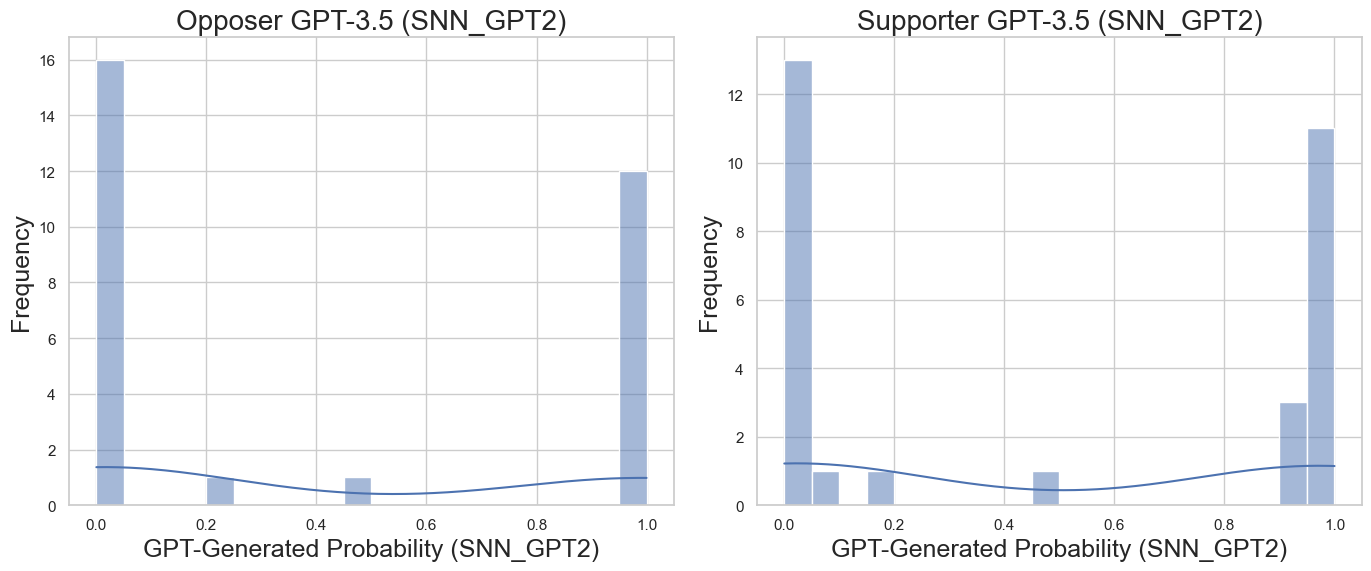

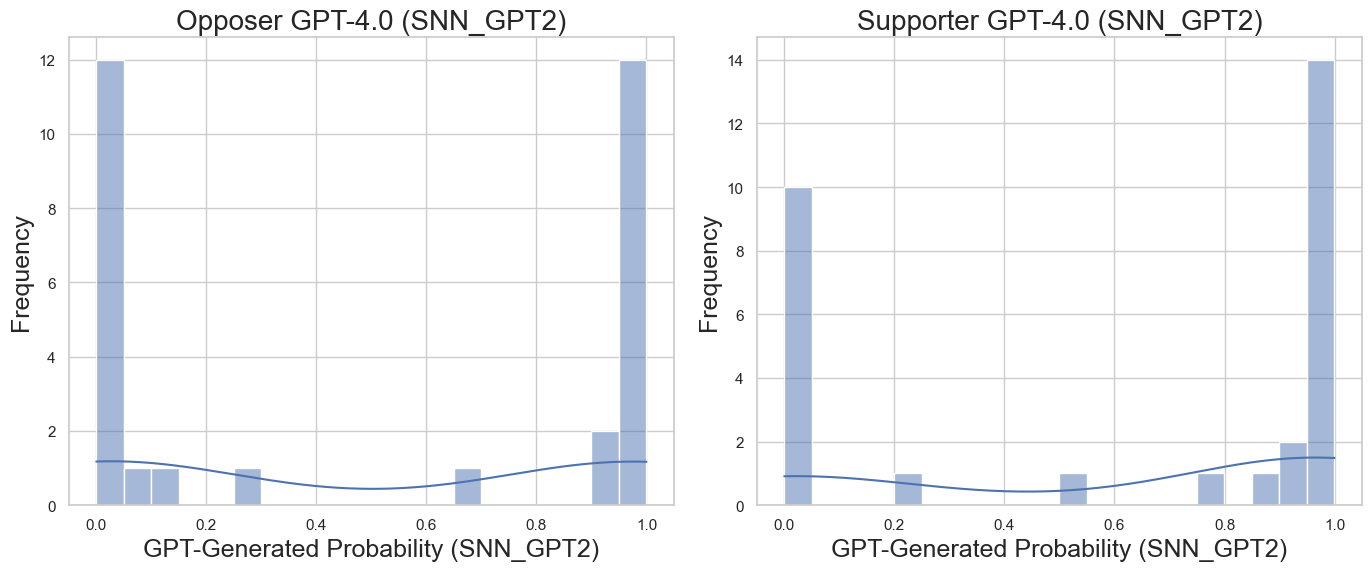

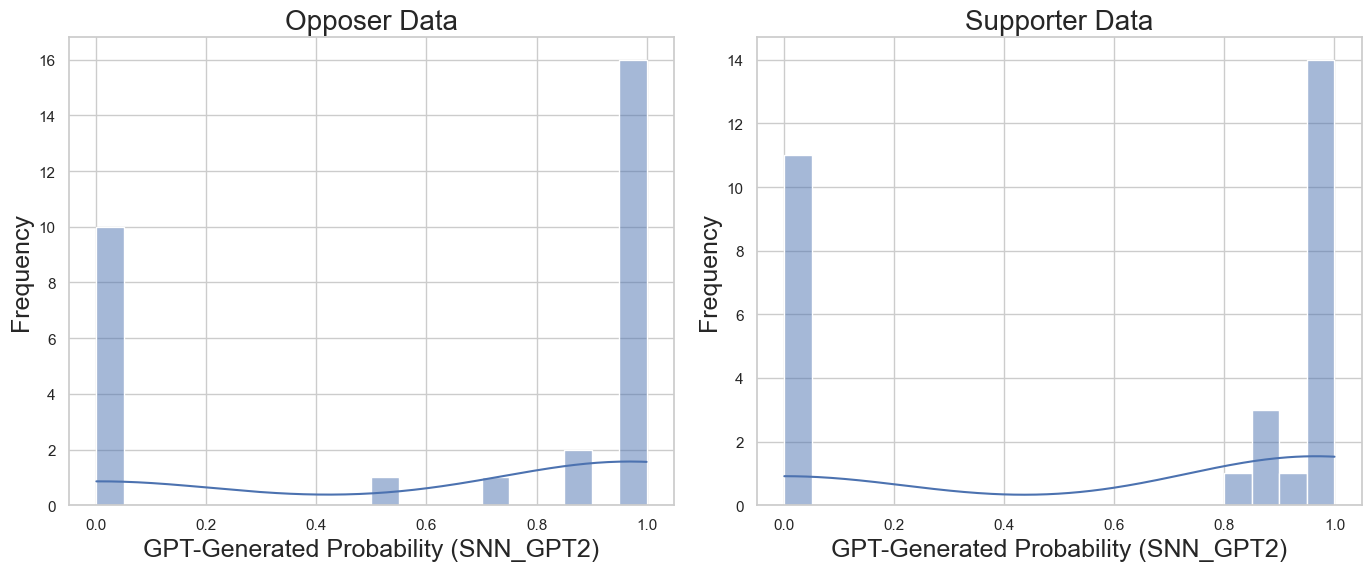

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting for GPT-3.5 Refined
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(opposer_results_with_metrics['gpt3_snn_gpt2_gpt_prob'], bins=20, kde=True)
plt.title("Opposer GPT-3.5 (SNN_GPT2)", fontsize=20)
plt.xlabel("GPT-Generated Probability (SNN_GPT2)", fontsize=18)
plt.ylabel("Frequency", fontsize=18)

plt.subplot(1, 2, 2)
sns.histplot(supporter_results_with_metrics['gpt3_snn_gpt2_gpt_prob'], bins=20, kde=True)
plt.title("Supporter GPT-3.5 (SNN_GPT2)", fontsize=20)
plt.xlabel("GPT-Generated Probability (SNN_GPT2)", fontsize=18)
plt.ylabel("Frequency", fontsize=18)

plt.tight_layout()
plt.show()

# Plotting for GPT-4.0 Original
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(opposer_results_with_metrics['gpt4_original_snn_gpt2_gpt_prob'], bins=20, kde=True)
plt.title("Opposer GPT-4.0 (SNN_GPT2)", fontsize=20)
plt.xlabel("GPT-Generated Probability (SNN_GPT2)", fontsize=18)
plt.ylabel("Frequency", fontsize=18)

plt.subplot(1, 2, 2)
sns.histplot(supporter_results_with_metrics['gpt4_original_snn_gpt2_gpt_prob'], bins=20, kde=True)
plt.title("Supporter GPT-4.0 (SNN_GPT2)", fontsize=20)
plt.xlabel("GPT-Generated Probability (SNN_GPT2)", fontsize=18)
plt.ylabel("Frequency", fontsize=18)

plt.tight_layout()
plt.show()

# Plotting for GPT-4.0 Refined
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(opposer_results_with_metrics['gpt4_gpt3_snn_gpt2_gpt_prob'], bins=20, kde=True)
plt.title("Opposer Data", fontsize=20)
plt.xlabel("GPT-Generated Probability (SNN_GPT2)", fontsize=18)
plt.ylabel("Frequency", fontsize=18)

plt.subplot(1, 2, 2)
sns.histplot(supporter_results_with_metrics['gpt4_gpt3_snn_gpt2_gpt_prob'], bins=20, kde=True)
plt.title("Supporter Data", fontsize=20)
plt.xlabel("GPT-Generated Probability (SNN_GPT2)", fontsize=18)
plt.ylabel("Frequency", fontsize=18)

plt.tight_layout()
plt.show()


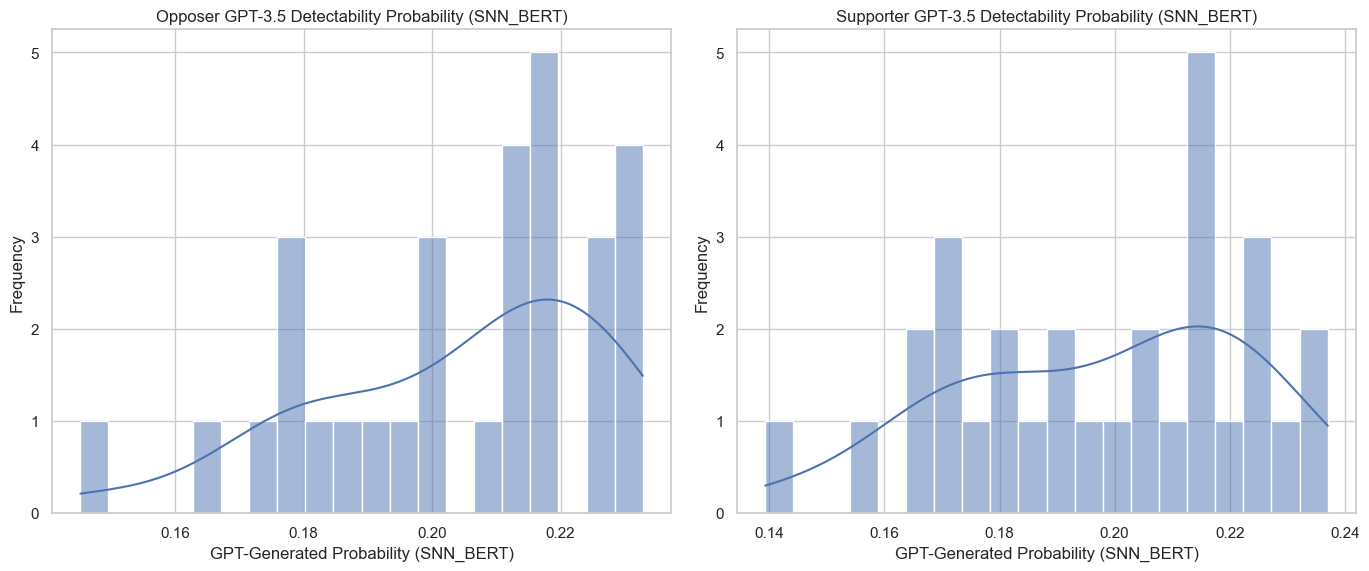

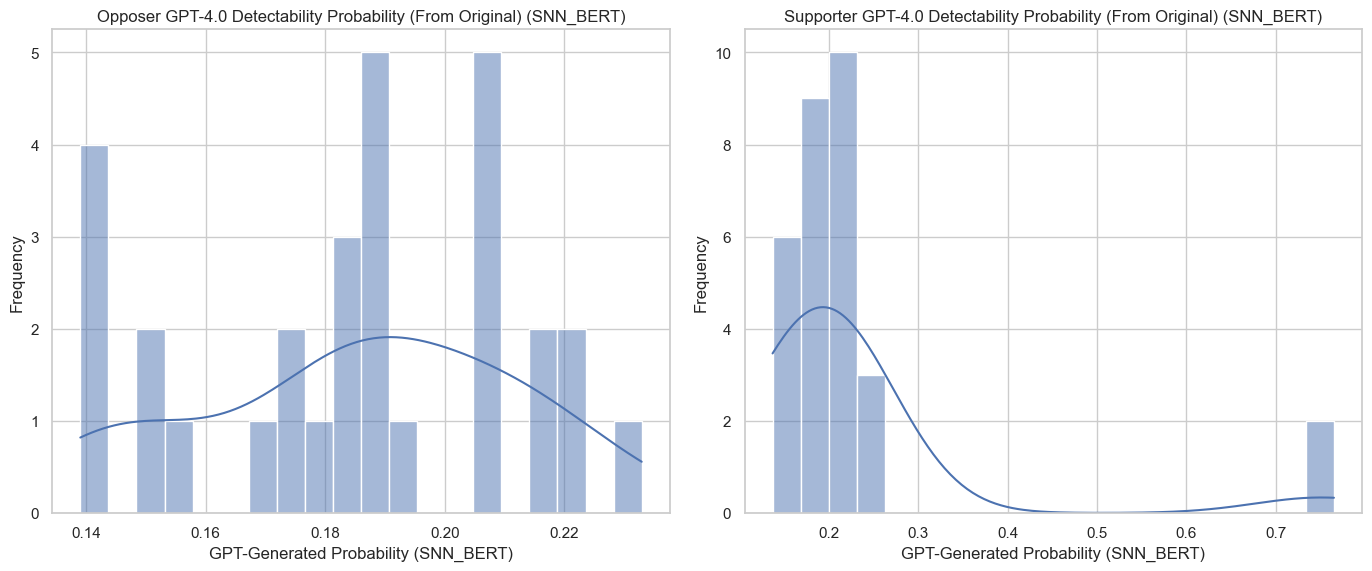

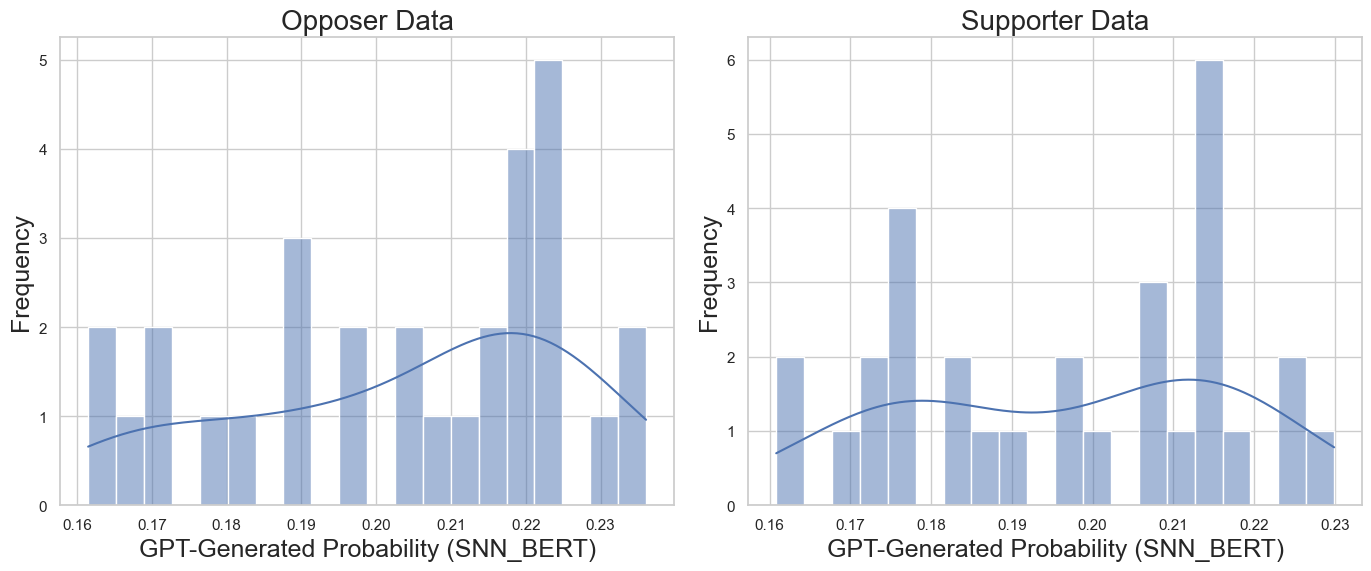

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# SNN_BERT Detectability (GPT-3.5 Refined)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(opposer_results_with_metrics['gpt3_snn_bert_gpt_prob'], bins=20, kde=True)
plt.title("Opposer GPT-3.5 Detectability Probability (SNN_BERT)")
plt.xlabel("GPT-Generated Probability (SNN_BERT)")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.histplot(supporter_results_with_metrics['gpt3_snn_bert_gpt_prob'], bins=20, kde=True)
plt.title("Supporter GPT-3.5 Detectability Probability (SNN_BERT)")
plt.xlabel("GPT-Generated Probability (SNN_BERT)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# SNN_BERT Detectability (GPT-4.0 Original)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(opposer_results_with_metrics['gpt4_original_snn_bert_gpt_prob'], bins=20, kde=True)
plt.title("Opposer GPT-4.0 Detectability Probability (From Original) (SNN_BERT)")
plt.xlabel("GPT-Generated Probability (SNN_BERT)")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.histplot(supporter_results_with_metrics['gpt4_original_snn_bert_gpt_prob'], bins=20, kde=True)
plt.title("Supporter GPT-4.0 Detectability Probability (From Original) (SNN_BERT)")
plt.xlabel("GPT-Generated Probability (SNN_BERT)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# SNN_BERT Detectability (GPT-4.0 Refined)
plt.figure(figsize=(14, 6))




plt.subplot(1, 2, 1)
sns.histplot(opposer_results_with_metrics['gpt4_gpt3_snn_bert_gpt_prob'], bins=20, kde=True)
plt.title("Opposer Data",fontsize=20)
plt.xlabel("GPT-Generated Probability (SNN_BERT)", fontsize=18)
plt.ylabel("Frequency", fontsize=18)

plt.subplot(1, 2, 2)
sns.histplot(supporter_results_with_metrics['gpt4_gpt3_snn_bert_gpt_prob'], bins=20, kde=True)
plt.title("Supporter Data",fontsize=20)
plt.xlabel("GPT-Generated Probability (SNN_BERT)", fontsize=18)
plt.ylabel("Frequency", fontsize=18)

plt.tight_layout()
plt.show()


In [21]:
# Function to calculate the frequency of GPT-generated vs Human-generated tweets
def calculate_gpt_vs_human(df, classification_column):
    gpt_count = df[classification_column].value_counts().get('GPT-generated', 0)
    human_count = df[classification_column].value_counts().get('Human-generated', 0)
    return gpt_count, human_count

# For Opposer Tweets
print("### OPPOSER Tweets ###")

# For SNN_BERT (Opposer)
print("\n### SNN_BERT Classifier (Opposer) ###")

# GPT-3.5 Refined (SNN_BERT)
gpt3_snn_bert_gpt_count, gpt3_snn_bert_human_count = calculate_gpt_vs_human(opposer_results_with_metrics, 'gpt3_snn_bert_detectability')
print(f"GPT-3.5 (SNN_BERT) - GPT-generated: {gpt3_snn_bert_gpt_count}, Human-generated: {gpt3_snn_bert_human_count}")

# GPT-4.0 Original (SNN_BERT)
gpt4_original_snn_bert_gpt_count, gpt4_original_snn_bert_human_count = calculate_gpt_vs_human(opposer_results_with_metrics, 'gpt4_original_snn_bert_detectability')
print(f"GPT-4.0 Original (SNN_BERT) - GPT-generated: {gpt4_original_snn_bert_gpt_count}, Human-generated: {gpt4_original_snn_bert_human_count}")

# GPT-4.0 Refined (SNN_BERT)
gpt4_refined_snn_bert_gpt_count, gpt4_refined_snn_bert_human_count = calculate_gpt_vs_human(opposer_results_with_metrics, 'gpt4_gpt3_snn_bert_detectability')
print(f"GPT-4.0 Refined (SNN_BERT) - GPT-generated: {gpt4_refined_snn_bert_gpt_count}, Human-generated: {gpt4_refined_snn_bert_human_count}")

# For SNN_GPT2 (Opposer)
print("\n### SNN_GPT2 Classifier (Opposer) ###")

# GPT-3.5 Refined (SNN_GPT2)
gpt3_snn_gpt2_gpt_count, gpt3_snn_gpt2_human_count = calculate_gpt_vs_human(opposer_results_with_metrics, 'gpt3_snn_gpt2_detectability')
print(f"GPT-3.5 (SNN_GPT2) - GPT-generated: {gpt3_snn_gpt2_gpt_count}, Human-generated: {gpt3_snn_gpt2_human_count}")

# GPT-4.0 Original (SNN_GPT2)
gpt4_original_snn_gpt2_gpt_count, gpt4_original_snn_gpt2_human_count = calculate_gpt_vs_human(opposer_results_with_metrics, 'gpt4_original_snn_gpt2_detectability')
print(f"GPT-4.0 Original (SNN_GPT2) - GPT-generated: {gpt4_original_snn_gpt2_gpt_count}, Human-generated: {gpt4_original_snn_gpt2_human_count}")

# GPT-4.0 Refined (SNN_GPT2)
gpt4_refined_snn_gpt2_gpt_count, gpt4_refined_snn_gpt2_human_count = calculate_gpt_vs_human(opposer_results_with_metrics, 'gpt4_gpt3_snn_gpt2_detectability')
print(f"GPT-4.0 Refined (SNN_GPT2) - GPT-generated: {gpt4_refined_snn_gpt2_gpt_count}, Human-generated: {gpt4_refined_snn_gpt2_human_count}")



### OPPOSER Tweets ###

### SNN_BERT Classifier (Opposer) ###
GPT-3.5 (SNN_BERT) - GPT-generated: 0, Human-generated: 30
GPT-4.0 Original (SNN_BERT) - GPT-generated: 0, Human-generated: 30
GPT-4.0 Refined (SNN_BERT) - GPT-generated: 0, Human-generated: 30

### SNN_GPT2 Classifier (Opposer) ###
GPT-3.5 (SNN_GPT2) - GPT-generated: 12, Human-generated: 18
GPT-4.0 Original (SNN_GPT2) - GPT-generated: 15, Human-generated: 15
GPT-4.0 Refined (SNN_GPT2) - GPT-generated: 20, Human-generated: 10


In [22]:
# For Supporter Tweets
print("\n### SUPPORTER Tweets ###")

# For SNN_BERT (Supporter)
print("\n### SNN_BERT Classifier (Supporter) ###")

# GPT-3.5 Refined (SNN_BERT)
gpt3_snn_bert_gpt_count_supporter, gpt3_snn_bert_human_count_supporter = calculate_gpt_vs_human(supporter_results_with_metrics, 'gpt3_snn_bert_detectability')
print(f"GPT-3.5 (SNN_BERT) - GPT-generated: {gpt3_snn_bert_gpt_count_supporter}, Human-generated: {gpt3_snn_bert_human_count_supporter}")

# GPT-4.0 Original (SNN_BERT)
gpt4_original_snn_bert_gpt_count_supporter, gpt4_original_snn_bert_human_count_supporter = calculate_gpt_vs_human(supporter_results_with_metrics, 'gpt4_original_snn_bert_detectability')
print(f"GPT-4.0 Original (SNN_BERT) - GPT-generated: {gpt4_original_snn_bert_gpt_count_supporter}, Human-generated: {gpt4_original_snn_bert_human_count_supporter}")

# GPT-4.0 Refined (SNN_BERT)
gpt4_refined_snn_bert_gpt_count_supporter, gpt4_refined_snn_bert_human_count_supporter = calculate_gpt_vs_human(supporter_results_with_metrics, 'gpt4_gpt3_snn_bert_detectability')
print(f"GPT-4.0 Refined (SNN_BERT) - GPT-generated: {gpt4_refined_snn_bert_gpt_count_supporter}, Human-generated: {gpt4_refined_snn_bert_human_count_supporter}")

# For SNN_GPT2 (Supporter)
print("\n### SNN_GPT2 Classifier (Supporter) ###")


# GPT-3.5 Refined (SNN_GPT2)
gpt3_snn_gpt2_gpt_count_supporter, gpt3_snn_gpt2_human_count_supporter = calculate_gpt_vs_human(supporter_results_with_metrics, 'gpt3_snn_gpt2_detectability')
print(f"GPT-3.5 (SNN_GPT2) - GPT-generated: {gpt3_snn_gpt2_gpt_count_supporter}, Human-generated: {gpt3_snn_gpt2_human_count_supporter}")

# GPT-4.0 Original (SNN_GPT2)
gpt4_original_snn_gpt2_gpt_count_supporter, gpt4_original_snn_gpt2_human_count_supporter = calculate_gpt_vs_human(supporter_results_with_metrics, 'gpt4_original_snn_gpt2_detectability')
print(f"GPT-4.0 Original (SNN_GPT2) - GPT-generated: {gpt4_original_snn_gpt2_gpt_count_supporter}, Human-generated: {gpt4_original_snn_gpt2_human_count_supporter}")

# GPT-4.0 Refined (SNN_GPT2)
gpt4_refined_snn_gpt2_gpt_count_supporter, gpt4_refined_snn_gpt2_human_count_supporter = calculate_gpt_vs_human(supporter_results_with_metrics, 'gpt4_gpt3_snn_gpt2_detectability')
print(f"GPT-4.0 Refined (SNN_GPT2) - GPT-generated: {gpt4_refined_snn_gpt2_gpt_count_supporter}, Human-generated: {gpt4_refined_snn_gpt2_human_count_supporter}")





### SUPPORTER Tweets ###

### SNN_BERT Classifier (Supporter) ###
GPT-3.5 (SNN_BERT) - GPT-generated: 0, Human-generated: 30
GPT-4.0 Original (SNN_BERT) - GPT-generated: 2, Human-generated: 28
GPT-4.0 Refined (SNN_BERT) - GPT-generated: 0, Human-generated: 30

### SNN_GPT2 Classifier (Supporter) ###
GPT-3.5 (SNN_GPT2) - GPT-generated: 14, Human-generated: 16
GPT-4.0 Original (SNN_GPT2) - GPT-generated: 19, Human-generated: 11
GPT-4.0 Refined (SNN_GPT2) - GPT-generated: 19, Human-generated: 11


In [23]:
# Function to find tweets where the classification shifts between models (e.g., from Human-generated to GPT-generated)
def find_classification_shifts_v2(df, gpt3_column, gpt4_original_column, gpt4_refined_column):
    """
    Find tweets where the classification shifts between models (e.g., from Human-generated to GPT-generated).
    
    Args:
        df (pd.DataFrame): DataFrame containing classification results for GPT-3.5, GPT-4.0 (Original), and GPT-4.0 (Refined).
        gpt3_column (str): Column name for GPT-3.5 classification.
        gpt4_original_column (str): Column name for GPT-4.0 (Original) classification.
        gpt4_refined_column (str): Column name for GPT-4.0 (Refined) classification.
    
    Returns:
        pd.DataFrame: DataFrame with tweets that showed major classification shifts.
    """
    # Filter for tweets where there's a shift in classification between any of the models
    classification_shift = df[
        ((df[gpt3_column] != df[gpt4_original_column]) & (df[gpt3_column] != 'unknown') & (df[gpt4_original_column] != 'unknown')) |
        ((df[gpt3_column] != df[gpt4_refined_column]) & (df[gpt3_column] != 'unknown') & (df[gpt4_refined_column] != 'unknown')) |
        ((df[gpt4_original_column] != df[gpt4_refined_column]) & (df[gpt4_original_column] != 'unknown') & (df[gpt4_refined_column] != 'unknown'))
    ]
    
    return classification_shift

# Now you can use the display_classification_shifts_v2 function as you intended
def display_classification_shifts_v2(df, gpt3_class_column, gpt4_original_class_column, gpt4_refined_class_column, num_examples=5):
    """
    Display tweets with major classification shifts and their corresponding metrics (BLEU, polarity, subjectivity).
    Includes the actual generated tweets for each model.
    
    Args:
        df (pd.DataFrame): DataFrame containing classification and metrics data.
        gpt3_class_column (str): Column name for GPT-3.5 classification.
        gpt4_original_class_column (str): Column name for GPT-4.0 (Original) classification.
        gpt4_refined_class_column (str): Column name for GPT-4.0 (Refined) classification.
        num_examples (int): Number of examples to display.
    
    Returns:
        None
    """
    # Step 1: Find tweets with classification shifts
    shifted_tweets = find_classification_shifts_v2(df, gpt3_class_column, gpt4_original_class_column, gpt4_refined_class_column)
    
    # Step 2: Display classification and metrics for each tweet
    for index, row in shifted_tweets.head(num_examples).iterrows():
        print(f"Tweet {index + 1} - Major Classification Shift Detected:")
        
        # Display the original tweet and generated tweets
        print(f"\nOriginal Tweet:\n{row['original_tweet']}")
        print(f"GPT-3.5 Refined Tweet:\n{row['gpt3_refined_tweet']}")
        print(f"GPT-4.0 Generated (Original):\n{row['gpt4_generated_from_original']}")
        print(f"GPT-4.0 Generated (Refined):\n{row['gpt4_generated_from_gpt3']}")
        
        # Display classification status for each stage
        print(f"\nClassifications:")
        print(f"GPT-3.5 Refined Tweet - Classification: {row[gpt3_class_column]}")
        print(f"GPT-4.0 Generated (Original) - Classification: {row[gpt4_original_class_column]}")
        print(f"GPT-4.0 Generated (Refined) - Classification: {row[gpt4_refined_class_column]}")
        
        # Display BLEU, polarity, and subjectivity for each stage
        print(f"\nMetrics:")
        print(f"BLEU Score (Original vs GPT-3.5 Refined): {calculate_bleu(row['original_tweet'], row['gpt3_refined_tweet'])}")
        print(f"Polarity (Original): {row['original_polarity']}, GPT-3.5: {row['gpt3_polarity']}")
        print(f"Subjectivity (Original): {row['original_subjectivity']}, GPT-3.5: {row['gpt3_subjectivity']}")
        
        print(f"BLEU Score (Original vs GPT-4.0 Original): {calculate_bleu(row['original_tweet'], row['gpt4_generated_from_original'])}")
        print(f"Polarity (GPT-4.0 Original): {row['gpt4_original_polarity']}")
        print(f"Subjectivity (GPT-4.0 Original): {row['gpt4_original_subjectivity']}")
        
        print(f"BLEU Score (Original vs GPT-4.0 Refined): {calculate_bleu(row['original_tweet'], row['gpt4_generated_from_gpt3'])}")
        print(f"Polarity (GPT-4.0 Refined): {row['gpt4_gpt3_polarity']}")
        print(f"Subjectivity (GPT-4.0 Refined): {row['gpt4_gpt3_subjectivity']}")
        
        print("-" * 80)



In [24]:
# Opposer Tweets - SNN_BERT Classifier
display_classification_shifts_v2(opposer_results_with_metrics, 
                                 'gpt3_snn_bert_detectability', 
                                 'gpt4_original_snn_bert_detectability', 
                                 'gpt4_gpt3_snn_bert_detectability',
                                 num_examples=3)

In [25]:
# Opposer Tweets - SNN_GPT2 Classifier
display_classification_shifts_v2(opposer_results_with_metrics, 
                                 'gpt3_snn_gpt2_detectability', 
                                 'gpt4_original_snn_gpt2_detectability', 
                                 'gpt4_gpt3_snn_gpt2_detectability',
                                 num_examples=3)

Tweet 1 - Major Classification Shift Detected:

Original Tweet:
BBC Fact Check on #ArsonEmergency claims.  https://t.co/UkPXWEYctl
GPT-3.5 Refined Tweet:
#Investigating the truth behind the #ArsonCrisis frenzy with the help of BBC Fact Check. https://t.co/UkPXWEYctl
GPT-4.0 Generated (Original):
BBC Fact Check addresses the claims regarding the #ArsonEmergency. https://t.co/UkPXWEYctl
GPT-4.0 Generated (Refined):
#Exploring the reality behind the #ArsonCrisis hype, aided by BBC Fact Check. https://t.co/UkPXWEYctl

Classifications:
GPT-3.5 Refined Tweet - Classification: Human-generated
GPT-4.0 Generated (Original) - Classification: GPT-generated
GPT-4.0 Generated (Refined) - Classification: Human-generated

Metrics:
BLEU Score (Original vs GPT-3.5 Refined): 0.17923344640485428
Polarity (Original): 0.0, GPT-3.5: 0.0009499999999999
Subjectivity (Original): 0.0, GPT-3.5: 0.42
BLEU Score (Original vs GPT-4.0 Original): 0.29420957081163696
Polarity (GPT-4.0 Original): 0.0
Subjectivity (GPT-

# Supporter

In [26]:
# Supporter Tweets - SNN_BERT Classifier
display_classification_shifts_v2(supporter_results_with_metrics, 
                                 'gpt3_snn_bert_detectability', 
                                 'gpt4_original_snn_bert_detectability', 
                                 'gpt4_gpt3_snn_bert_detectability',
                                 num_examples=3)

Tweet 3 - Major Classification Shift Detected:

Original Tweet:
😆😆😆😆😆😆😆😆😆 #ArsonEmergency https://t.co/AlWzObzZb3
GPT-3.5 Refined Tweet:
🔥🚒 The escalation of fire-related occurrences is definitely not something to joke about. 😆😆😆😆😆😆😆😆 #ArsonCrisis https://t.co/AlWzObzZb3
GPT-4.0 Generated (Original):
😂😂😂😂😂😂😂😂😂 #FireDisaster https://t.co/AlWzObzZb3
GPT-4.0 Generated (Refined):
🔥🚒 The rise in fire incidents is certainly no laughing matter. 😆😆😆😆😆😆😆😆 #ArsonCrisis https://t.co/AlWzObzZb3

Classifications:
GPT-3.5 Refined Tweet - Classification: Human-generated
GPT-4.0 Generated (Original) - Classification: GPT-generated
GPT-4.0 Generated (Refined) - Classification: Human-generated

Metrics:
BLEU Score (Original vs GPT-3.5 Refined): 0.05121488961114836
Polarity (Original): 0.4806, GPT-3.5: 0.46635
Subjectivity (Original): 0.2645, GPT-3.5: 0.387
BLEU Score (Original vs GPT-4.0 Original): 0.21711852081087685
Polarity (GPT-4.0 Original): 0.48765
Subjectivity (GPT-4.0 Original): 0.1065
BLEU Scor

In [27]:
# Supporter Tweets - SNN_GPT2 Classifier
display_classification_shifts_v2(supporter_results_with_metrics, 
                                 'gpt3_snn_gpt2_detectability', 
                                 'gpt4_original_snn_gpt2_detectability', 
                                 'gpt4_gpt3_snn_gpt2_detectability',
                                 num_examples=3)

Tweet 1 - Major Classification Shift Detected:

Original Tweet:
ARSON EMERGENCY UPDATE

"716 fires this season did not occur naturally."

Link https://t.co/JEbImnqgyC

#ArsonEmergency not #ClimateEmergency.
GPT-3.5 Refined Tweet:
"Breaking: After investigation, no evidence of natural causes for the 716 fires during the #ArsonEmergency. Remain alert and report any questionable behavior. Link https://t.co/JEbImnqgyC."
GPT-4.0 Generated (Original):
ARSON EMERGENCY ALERT

"This season, 716 fires were not caused by natural events."

Link https://t.co/JEbImnqgyC

#ArsonEmergency not #ClimateEmergency
GPT-4.0 Generated (Refined):
News Update: Following an investigation, no signs of natural causes have been found for the 716 fires linked to the #ArsonEmergency. Stay vigilant and notify authorities of any suspicious activity. Link https://t.co/JEbImnqgyC.

Classifications:
GPT-3.5 Refined Tweet - Classification: GPT-generated
GPT-4.0 Generated (Original) - Classification: GPT-generated
GPT-4.0 